<a href="https://www.kaggle.com/code/arfin1403/gpt-2-text-generation-with-prompts-and-dataset?scriptVersionId=282486032" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🎇**GPT-2 Text Generation** <a class="anchor"  id="h1"></a>

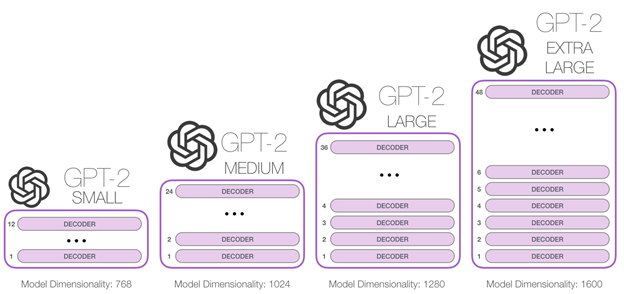

For our text generation pipeline, we rely on Hugging Face Transformers. This versatile package, denoted as 🤗 (Hugging Face) Transformers, was previously known as PyTorch-transformers and PyTorch-pretrained-bert. It provides a collection of general-purpose architectures, including BERT, GPT-2, RoBERTa, XLM, DistilBert, and XLNet, suitable for Natural Language Understanding (NLU) and Natural Language Generation (NLG) tasks. It boasts a wide array of over 32 pre-trained models, available in more than 100 languages, and offers seamless compatibility between TensorFlow 2.0 and PyTorch.

Essentially, Hugging Face Transformers is an extensive Python package equipped with pre-defined functions, pipelines, and models that can be readily employed for a variety of natural language processing tasks. Notably, it also includes GPT-2 Tokenizer and Models as part of its offerings.

### 📋**Table of Contents**

* [GPT-2 Text Generation](#h1)

* [Setting up the Environment](#h2)

* [Importing Libraries](#h3)

* [Convert the Sentences into the Tokens](#h4)

* [Model's Vocab](#h5) 

* [Generate the text given the sentence](#h6)

    * [1. Greedy Search](#h7)

    * [2. Beam Search](#h8)

    * [3. Random Sampling](#h9)

    * [4. Top-K Sampling](#h10)

    * [5. Top-P Sampling](#h11)

    * [6. Top-K and Top-P Sampling](#h12)

* [Generate the text with dataset](#h13)

    * [Download Shakespeare dataset from Huggingface datasets hub](#h14)

    * [Tokenize all the texts](#h15)

    * [Split whole dataset into smaller sets of blocks](#h16)

    * [Initialize Trainer](#h17)

    * [Cleaning Memory](#h18)

    * [Perform Training](#h19)

    * [Evaluate Model](#h20)

    * [Generate Samples](#h21)

        * [1. Greedy Search Text Generation](#h22)

        * [2. Beam Search Text Generation](#h23) 
        
        * [3. Random Sampling Text Generation](#h24)
        
        * [4. Top-K Sampling Text Generation](#h25)
        
        * [5. Top-P Sampling Text Generation](#h26)
        
        * [6. Top-K and Top-P Sampling Text Generation](#h27)

# 🌠**Setting up the Environment** <a class="anchor"  id="h2"></a>

In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install GPUtil

# 🌠**Importing Libraries** <a class="anchor"  id="h3"></a>

In [2]:
import torch
import pandas as pd
from numba import cuda
from datasets import load_dataset
from GPUtil import showUtilization as gpu_usage
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer, default_data_collator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 🌠**Convert the Sentences into the Tokens** <a class="anchor"  id="h4"></a>

GPT-2 comes in four different sizes:

* **124M (default)**: referred to as the "**small**" model, which occupies 500MB of storage space.

* **355M**: known as the "**medium**" model, requiring 1.5GB of disk space.

* **774M**: categorized as the "**large**" model.

* **1558M**: identified as the "**extra large**" model.

In [3]:
%%capture
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [4]:
%%capture
model = GPT2LMHeadModel.from_pretrained('gpt2', 
                                        pad_token_id=tokenizer.eos_token_id)

# 🌠**Model's Vocab** <a class="anchor"  id="h5"></a>

In [5]:
print("The max model length is {} for this model".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))

The max model length is 1024 for this model
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256


In [6]:
tokenizer.vocab_size

50257

In [7]:
tokenizer

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

In [8]:
tokenizer.all_special_tokens

['<|endoftext|>']

In [9]:
tokenizer.eos_token_id

50256

GPT-2 does not employ padding. Its default maximum supported sentence length is 1024.

In [10]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

In [11]:
sentence = 'I am an Artificial Intelligence Developer'
input_ids  = tokenizer.encode(sentence, 
                              return_tensors = 'pt')

In [12]:
input_ids 

tensor([[   40,   716,   281, 35941,  9345, 23836]])

In [13]:
tokenizer.decode(input_ids[0][3])

' Artificial'

# 🌠**Generate the text given the sentence** <a class="anchor"  id="h6"></a>

## 📝**1. Greedy Search** <a class="anchor"  id="h7"></a>

With Greedy Search, the next word is predicted based on the word with the highest probability, as represented by the following equation:

wt = argmaxw P(w | w1:t−1)

At each time step t, the word with the highest conditional probability is chosen.

In [14]:
greedy_output = model.generate(input_ids,
                               max_length=100,
                               no_repeat_ngram_size=2)

In [15]:
for i, output in enumerate(greedy_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: I am an Artificial Intelligence Developer. I am a software developer. And I'm a programmer.

I'm not a computer scientist. But I do have a lot of experience in the field of Artificial intelligence. So I think that I can help you understand the challenges of AI. You can learn about the problems of artificial intelligence and how they can be solved. It's not just about solving problems. There are many other things that can go wrong. We can't just solve problems by solving them...



However, this simplistic approach has its limitations. As we can observe in our results, the generated text quickly starts to repeat itself. The main drawback of Greedy Search is that it tends to favor words with high probabilities, potentially overlooking more diverse and interesting word combinations. This limitation can be mitigated by implementing Beam Search.

## 📝**2. Beam Search** <a class="anchor"  id="h8"></a>

In [16]:
beam_output = model.generate(input_ids, 
                             max_length = 100, 
                             num_beams=5,
                             num_return_sequences=5,
                             no_repeat_ngram_size=2, 
                             early_stopping=True)

The "**num_beams**" parameter in a language model is a setting that determines the quantity of "**beams**" employed during the beam search process. In the context of beam search, the model creates multiple potential sequences of words, often referred to as "hypotheses," which are potential continuations of a given input. At each stage, the algorithm maintains and evaluates the top "**num_beams**" hypotheses.

The rationale for employing multiple beams is to enhance the likelihood of identifying the most appropriate sequence of words that follows the input. For example, if the model is tasked with generating a sentence that begins with "**The cat**," utilizing one beam might lead to "**The cat is**," while using two beams could produce both "**The cat is**" and "**The cat sits.**" By considering various hypotheses, beam search can explore multiple avenues and ultimately select the one with the highest likelihood of being the optimal sequence.

It's essential to note, however, that increasing the number of beams also escalates the computational demands of the algorithm. This is due to the necessity for the model to create and assess multiple hypotheses at each step, which can be time-intensive. Consequently, the selection of the "num_beams" parameter must strike a balance between computational efficiency and the quality of the generated text.

In [17]:
beam_output

tensor([[   40,   716,   281, 35941,  9345, 23836,    13,   314,   423,   587,
          1762,   319,  9552,   329,   257,   890,   640,   290,   314,   716,
           845,  6568,   546,   262,  2003,   286,  9552,    13,   198,   198,
            40,   423,   257,  1256,   286,  1998,   287,   262,  2214,   286,
         11666,  4430,    13,   554,   262,   938,  1178,   812,    11,   314,
          1053,   587,  2950,   287,   257,  1271,   286,  1180,  4493,    11,
          1390,   262,  2478,   286,   262,  9552,  3859,   329,  3012,   338,
          5565,  3859,    11,   290,   262,  6282,   286,   281,  9552,    12,
         12293,  5175,   598,   329,  4196,   338,  8969,  3859,    13,  2312,
          4493,   423,  2957,   502,   284,   262,  7664,   326,  9552,   318],
        [   40,   716,   281, 35941,  9345, 23836,    13,   314,   423,   587,
          1762,   319,  9552,   329,   257,   890,   640,   290,   314,   716,
           845,  6568,   546,   262,  2003,   286, 

In [18]:
for i, output in enumerate(beam_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: I am an Artificial Intelligence Developer. I have been working on AI for a long time and I am very excited about the future of AI.

I have a lot of experience in the field of artificial intelligence. In the last few years, I've been involved in a number of different projects, including the development of the AI platform for Google's Android platform, and the creation of an AI-powered mobile app for Apple's iOS platform. These projects have led me to the conclusion that AI is...

1: I am an Artificial Intelligence Developer. I have been working on AI for a long time and I am very excited about the future of AI.

I have a lot of experience in the field of artificial intelligence. In the last few years, I've been involved in a number of different projects, including the development of the AI platform for Google's Android platform, and the creation of an AI-powered mobile app for Apple's iOS platform. These projects have led me to believe that AI is a...

2: I am an Artificial Intellige

The current set of five different beam hypotheses seems to produce similar outputs. However, increasing the number of beams would likely introduce more variation among these individual beams. It's important to note that while Beam Search is a useful technique, it's not without its limitations. It performs well when the generated text length remains relatively constant, such as in translation or summarization tasks. Yet, it struggles with open-ended problems like dialogue or story generation. This is because finding the right balance between the number of beams and the no_repeat_ngram_size becomes more challenging in such scenarios.

## 📝**3. Random Sampling** <a class="anchor"  id="h9"></a>

Now, let's delve into the realm of indeterministic decodings through random sampling. Instead of strictly adhering to a predetermined path to generate text with the highest probability, we opt to select the next word at random based on its conditional probability distribution, following the equation:

wt ∼ P(w | w1:t−1)

However, introducing this element of randomness can lead to incoherent generated text. To address this, we can employ the temperature parameter, which adjusts the balance between high and low probability words during sampling.

To implement sampling, we simply set "**do_sample**" to "**True,**" and for the purpose of demonstration, we set "**top_k**" to 0.

In [19]:
random_output = model.generate(input_ids, 
                               do_sample=True, 
                               max_length=100, 
                               top_k=0, 
                               temperature=0.8)

In [20]:
for i, output in enumerate(random_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: I am an Artificial Intelligence Developer, I have design and development/development skills above average for a small team and have been able to contribute to a large number of projects over the years. I have been a registered Principal Editor in Inventor, CMO, and an in the business side of my major....



## 📝**4. Top-K Sampling** <a class="anchor"  id="h10"></a>

In Top-K sampling, we focus on selecting the top k most likely next words, effectively concentrating the entire probability mass on these k words. Instead of altering the probabilities of high and low probability words, we simply eliminate the low probability words from consideration. To implement this, we only need to set the "top_k" parameter to determine how many of the top words we want to include in our conditional probability distribution.

In [21]:
top_k_output = model.generate(input_ids, 
                              do_sample=True, 
                              max_length=100, 
                              top_k=50)

In [22]:
for i, output in enumerate(top_k_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: I am an Artificial Intelligence Developer. For my early work, I started to work in a tech incubator where I worked on a lot of security, so I was really lucky to have a successful start-up there.

What do you hope to accomplish while working in the same room?

In the same room, I'd like to work in a lab where we'll use the same tools and the same technologies and share ideas. I'm sure that I will enjoy being part of the...



## 📝**5. Top-P Sampling** <a class="anchor"  id="h11"></a>

Top-P sampling, also known as nucleus sampling, shares similarities with Top-K sampling, but with a distinctive approach. Instead of selecting the top k most likely words, it focuses on choosing the smallest set of words for which the cumulative probability exceeds a given threshold, denoted as "p." In this method, the entire probability mass is then shifted to the words within this set.

The key distinction between Top-K and Top-P sampling lies in the flexibility of the set's size. In Top-K sampling, the set size remains fixed, while in Top-P sampling, the size can vary. To implement Top-P sampling, simply set "top_k" to 0 and specify a value for "top_p."

In [23]:
top_p_output = model.generate(input_ids, 
                              do_sample=True, 
                              max_length=100, 
                              top_p=0.8, 
                              top_k=0)

In [24]:
for i, output in enumerate(top_p_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: I am an Artificial Intelligence Developer. I am committed to delivering the best ever mobile apps on mobile devices. So please make your visit to the Google Play Store just a few days ahead of time. All I ask is that you be open to learning about new tools, and all I ask is that you show a dedication to the project and that you understand how to support it as much as possible. Please do not hesitate to ask questions, share your opinion on my blog, or even give feedback in any...



## 📝**6. Top-K and Top-P Sampling** <a class="anchor"  id="h12"></a>

As you might have anticipated, we have the flexibility to utilize both Top-K and Top-P sampling techniques in our approach. This combination helps mitigate the inclusion of unusual or low-probability words while enabling a dynamic selection size. To implement this, we simply need to specify values for both "top_k" and "top_p." Additionally, if desired, we can incorporate the initial temperature parameter. Now, let's assess the model's performance after integrating all these components. We will examine the top 5 results to gauge the diversity of our generated responses.

In [25]:
top_k_p_outputs = model.generate(input_ids,
                                 do_sample=True, 
                                 max_length=2*100,                             
                                 top_k=50, 
                                 top_p=0.85, 
                                 num_return_sequences=5)

In [26]:
for i, output in enumerate(top_k_p_outputs):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: I am an Artificial Intelligence Developer at Cloud Foundry, an Open Source Technology firm that has developed many of the most popular cloud services for both Android and iOS. I'm also a Certified Software Engineer at CIO, where I am responsible for building and running our own web applications for enterprise customers.

You can read more about my experience and work here.

To see how I have been able to become an engineer here:

http://learnengineer.com/

https://www.linkedin.com/company/I-Am-An-An-Automation-Engineer/

Please check out the following video.

How to Become an Engineer...

1: I am an Artificial Intelligence Developer, and this is what I work on for my projects.

This is the core code and tools of my company. It is a very important part of my life. I am an Entrepreneur and that is where I work. The code is distributed under my company's open source license. This means you can redistribute the code without any fees (like I am doing here) and it is open source under the

# 🌠**Generate the text with dataset** <a class="anchor"  id="h13"></a>

## 🎇**Download Shakespeare dataset from Huggingface datasets hub** <a class="anchor"  id="h14"></a>

In [27]:
%%capture
dataset_name = "tiny_shakespeare"
cache_dir = "lm_dataset/"
datasets = load_dataset(dataset_name, cache_dir=cache_dir)

In [28]:
datasets

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

In [29]:
#datasets['train'][:1]

## 🎇**Tokenize all the texts** <a class="anchor"  id="h15"></a>

In [30]:
column_names = datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]

def tokenize_function(examples):
    output = tokenizer(examples[text_column_name])
    return output

tokenized_datasets = datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=column_names,
    desc="Running tokenizer on dataset")

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (301966 > 1024). Running this sequence through the model will result in indexing errors


Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

## 🎇**Split whole dataset into smaller sets of blocks** <a class="anchor"  id="h16"></a>

In [31]:
block_size = tokenizer.model_max_length
if block_size > 1024:
    block_size = 1024
    
def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()}
    result["labels"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    desc=f"Grouping texts in chunks of {block_size}")

Grouping texts in chunks of 1024:   0%|          | 0/1 [00:00<?, ?ba/s]

Grouping texts in chunks of 1024:   0%|          | 0/1 [00:00<?, ?ba/s]

Grouping texts in chunks of 1024:   0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
train_dataset = lm_datasets["train"]
eval_dataset = lm_datasets["validation"]

## 🎇**Initialize Trainer** <a class="anchor"  id="h17"></a>

In [33]:
training_args = TrainingArguments(output_dir = "output/", 
                                  per_device_train_batch_size=1, 
                                  num_train_epochs=50, 
                                  save_total_limit=1,
                                  report_to=None)

In [34]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer=tokenizer,
                  data_collator=default_data_collator)

## 🎇**Cleaning Memory** <a class="anchor"  id="h18"></a>

In [35]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 | 16% |  5% |


In [36]:
torch.cuda.empty_cache()

## 🎇**Perform Training** <a class="anchor"  id="h19"></a>

In [37]:
import os
os.environ["WANDB_DISABLED"] = "true"

train_result = trainer.train()

wandb: Tracking run with wandb version 0.15.9
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Step,Training Loss
500,3.486100
1000,3.163000
1500,2.946800
2000,2.732600
2500,2.543700
3000,2.380400
3500,2.204300
4000,2.047900
4500,1.911300
5000,1.786800


## 🎇**Evaluate Model** <a class="anchor"  id="h20"></a>

In [38]:
trainer.save_model()

metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

trainer.save_state()

***** train metrics *****
  epoch                    =       50.0
  total_flos               =  7154406GF
  train_loss               =      1.548
  train_runtime            = 0:53:14.33
  train_samples_per_second =      4.602
  train_steps_per_second   =      4.602


## 📃**Generate Samples** <a class="anchor"  id="h21"></a>

### 📝**1. Greedy Search Text Generation** <a class="anchor"  id="h22"></a>

In [39]:
torch.manual_seed(2)

ids = tokenizer.encode('One does not simply walk into',
                       return_tensors='pt').cuda()

In [40]:
greedy_output = model.generate(ids,
                               max_length=100,
                               no_repeat_ngram_size=2)

In [41]:
for i, output in enumerate(greedy_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: One does not simply walk into a room and yields up his or her body
To such as have no more in common with him;
But in one respect he differs from all others; and
For one thing, he hath in himself a nature unlike
any in nature, and in being thus most
brave, to break from him.

LUCIO:
This is a brave fellow; for he is one
That will, in a word, do more than one thousand...



### 📝**2. Beam Search Text Generation** <a class="anchor"  id="h23"></a>

In [42]:
beam_output = model.generate(ids, 
                             max_length = 100, 
                             num_beams=5,
                             num_return_sequences=5,
                             no_repeat_ngram_size=2, 
                             early_stopping=True)

In [43]:
for i, output in enumerate(beam_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: One does not simply walk into a man's bosom and take his clothes
from him; for I have seen such a thing.

LADY ANNE:
O Warwick, thou art the first that ever didst bend
That wronged thyself in the view of others!
The army of the queen am I arm'd against;
And I, against thy back, will turn the diadem
On thy head, and burn the principal of thy pride
With the...

1: One does not simply walk into a man's bosom and take his clothes
from him; for I have seen such a thing.

LADY ANNE:
O Warwick, thou art the first that ever didst bend
That wronged thyself in the view of others!
The army of the queen am I arm'd against;
And I, against thy back, will turn the diadem
On thy head, and burn the principal of thy pride
With that...

2: One does not simply walk into a man's bosom and take his clothes
from him; for I have seen such a thing.

LADY ANNE:
O Warwick, thou art the first that ever didst bend
That wronged thyself in the view of others!
The army of the queen am I arm'd against;
And I, again

### 📝**3. Random Sampling Text Generation** <a class="anchor"  id="h24"></a>

In [44]:
random_output = model.generate(ids, 
                               do_sample=True, 
                               max_length=100, 
                               top_k=0, 
                               temperature=0.8)

In [45]:
for i, output in enumerate(random_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: One does not simply walk into a man's mouth and speak;
For I have heard some of these spoken. Thou hast undone thyself.

ROMEO:
Thou detestable traitor, I have seen thy face.

BENVOLIO:
O, make me happy by having him.

MERCUTIO:
And happy too, is it so: a woman is wont to chide.

ROMEO:
He chides for his...



### 📝**4. Top-K Sampling Text Generation** <a class="anchor"  id="h25"></a>

In [46]:
top_k_output = model.generate(ids, 
                              do_sample=True, 
                              max_length=100, 
                              top_k=50)

In [47]:
for i, output in enumerate(top_k_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: One does not simply walk into this world;
And that the naked traveller be king,
His acts of violence transported to the end;
Yet, in this world he is king; and I, his wife,
Can no longer say 'I love thee'
His warlike father advised him to, and I, his wife,
Were angels and nature no better pleased:
For why, 'tis my husband's will,
And I, his wife, should that be so...



### 📝**5. Top-P Sampling Text Generation** <a class="anchor"  id="h26"></a>

In [48]:
top_p_output = model.generate(ids, 
                              do_sample=True, 
                              max_length=100, 
                              top_p=0.8, 
                              top_k=0)

In [49]:
for i, output in enumerate(top_p_output):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: One does not simply walk into the mind of the dull;
And yields too much to the common feeling.

Second Murderer:
What rages here in this cell?

CLARENCE:
Let black magic apprehend
This murderous wretch: he is come to know
His evil done, and by that knowledge apprehends
The evil done.

Third Murderer:
What rages here in this cell?

CLARENCE:
That he choose...



### 📝**6. Top-K and Top-P Sampling Text Generation** <a class="anchor"  id="h27"></a>

In [50]:
top_k_p_outputs = model.generate(ids,
                                 do_sample=True, 
                                 max_length=2*100,                             
                                 top_k=50, 
                                 top_p=0.85, 
                                 num_return_sequences=5)

In [51]:
for i, output in enumerate(top_k_p_outputs):
    print("{}: {}...".format(i, tokenizer.decode(output, 
                                                 skip_special_tokens=True)))
    print('')

0: One does not simply walk into the world;
One at a time, some one at a time,
Could within a mile encompass all the earth,
And nothing can be more than the farthest world,
Within whose vastness all your body is,
When you are cold.

FLORIZEL:
So had you never been cold;
But now you have, since you can no more but think it,
Cold does encompass your thinking;
And cold will cloud your thought;
Since you cannot think it so, do not take
Your apprehension with your apprehension.

LEONTES:
It is a charge he makes against my better nature,
Because I abhor his rude delights. It is spoke so,
More than with thunder or with wind; so goes:
I am no meteor; yet meteor I can behold,
Lords circling in the clouds, that roused up their fury,
To dash down and throw their...

1: One does not simply walk into a man's bosom;
He, in aught, may move or move; a naked man by his garments,
Is not naked in the sense of apparel.
What he does see, he humbles him with precept;
But whether his folly or what contempt
H